# Over-fitting and Under-fitting

Underfitting is when a model can still be improved, becuase it's not powerful enough for the situtation, it's over-regularized (over simplified), or maybe it's just not been trained enough. Overfitting on the other hand is when the model starts to memorize the training data and draw patterns that don't (or aren't supposed to) apply to the test data. You have to strike a balance.
[link](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit)

In [1]:
import tensorflow as tf

print(tf.__version__)
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling


from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import pathlib
import shutil
import tempfile


2.8.0


In [2]:
logdir = pathlib.Path(tempfile.mkdtemp()) / "tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)


### Higgs dataset

Just a dataset. Using tf's build in function to grab this dataset for us. It contains 11,000,000 examples, each with 28 features, and a binary class label.


In [3]:
gz = tf.keras.utils.get_file(
    "HIGGS.csv.gz", "http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz"
)
FEATURES = 28


This Tf function allows the dataset to be read without first having to be decompressed


In [4]:
ds = tf.data.experimental.CsvDataset(
    gz, [float()] * (FEATURES + 1), compression_type="GZIP"
)


2022-06-12 00:22:46.088644: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


That csv reader class returns a list of scalars for each record. The following function repacks that list of scalars into a (feature_vector, label) pair.


In [5]:
def pack_row(*row):
    label = row[0]
    features = tf.stack(row[1:], 1)
    return features, label


I guess TF is optimized to work with large datasets, so the best way to repack this function is to take them in batches of 10,000 from the dataset instead of one at a time


In [6]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()


tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


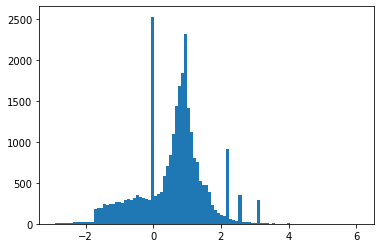

In [7]:
for features,label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins = 101)


While there's much more data, we're only going to use the first 1k for validation and the next 10k for training.


In [8]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN // BATCH_SIZE


Using tensorflow's take, skip, and cache functions on the dataset


In [9]:
val_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()
train_ds


<CacheDataset element_spec=(TensorSpec(shape=(28,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

Currently both the val_ds and train_ds are going to contain individual values, but we want them batched. Or rather, tensorflow wants them batched. Because the train data might be in some sort of order, we're going to shuffle it before batching.


In [10]:
val_ds = val_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)


Many models train better by reducing the learning rate during the training. This hyperbolically reduces the training rate to 1/2 @ 1000 epochs, 1/3 @ 2000 epochs, and so on.


In [11]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001, decay_steps=STEPS_PER_EPOCH * 1000, decay_rate=1, staircase=False
)


def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)


This graphs the learning rate over epochs


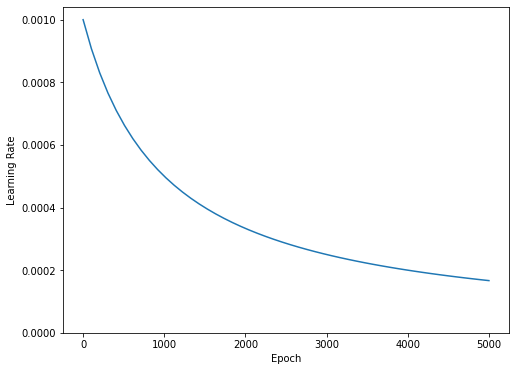

In [12]:
step = np.linspace(0, 100000)
lr = lr_schedule(step)
plt.figure(figsize=(8, 6))
plt.plot(step / STEPS_PER_EPOCH, lr)
plt.ylim((0, max(plt.ylim())))
plt.xlabel("Epoch")
_ = plt.ylabel("Learning Rate")


The `EpochDots` function prints a `.` for each epoch, and full metrics every 100 epochs. This is good when using many small epochs. The `EarlyStopping` monitors `val_binary_crossentropy` and prevents very long training times. Finally, `TensorBoard` will create logs for the training.


In [13]:
def get_callbacks(name):
    return (
        tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(
            monitor="val_binary_crossentropy", patience=200
        ),
        tf.keras.callbacks.TensorBoard(logdir / name),
    )


Creating a function to compile and fit future models


In [14]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
    if optimizer is None:
        optimizer = get_optimizer()
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=(
            tf.keras.losses.BinaryCrossentropy(
                from_logits=True, name="binary_crossentropy"
            ),
            "accuracy",
        ),
    )
    model.summary()

    history = model.fit(
        train_ds,
        steps_per_epoch=STEPS_PER_EPOCH,
        epochs=max_epochs,
        validation_data=val_ds,
        callbacks=get_callbacks(name),
        verbose=0,
    )
    return history


Now we're going to start to train the models.


In [15]:
tiny_model = tf.keras.Sequential(
    (
        tf.keras.layers.Dense(16, activation="elu", input_shape=(FEATURES,)),
        tf.keras.layers.Dense(1),
    )
)


In [16]:
size_histories = {}

In [17]:
size_histories["Tiny"] = compile_and_fit(tiny_model, "sizes/Tiny")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                464       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________


2022-06-12 00:30:31.510149: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1 of 10000
2022-06-12 00:30:31.510179: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2 of 10000
2022-06-12 00:30:31.510189: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 3 of 10000
2022-06-12 00:30:31.510195: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 4 of 10000
2022-06-12 00:30:31.510210: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 5 of 10000
2022-06-12 00:30:31.510217: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 6 of 10000
2022-06-12 00:30:31.510223: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer 


Epoch: 0, accuracy:0.4850,  binary_crossentropy:0.8505,  loss:0.8505,  val_accuracy:0.4700,  val_binary_crossentropy:0.7857,  val_loss:0.7857,  
....................................................................................................
Epoch: 100, accuracy:0.6045,  binary_crossentropy:0.6239,  loss:0.6239,  val_accuracy:0.5880,  val_binary_crossentropy:0.6243,  val_loss:0.6243,  
....................................................................................................
Epoch: 200, accuracy:0.6320,  binary_crossentropy:0.6097,  loss:0.6097,  val_accuracy:0.5910,  val_binary_crossentropy:0.6138,  val_loss:0.6138,  
....................................................................................................
Epoch: 300, accuracy:0.6436,  binary_crossentropy:0.6026,  loss:0.6026,  val_accuracy:0.6360,  val_binary_crossentropy:0.6049,  val_loss:0.6049,  
....................................................................................................
Epoch: 40

Now we're going to see how well the model did

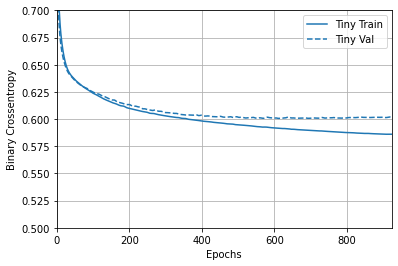

In [18]:
plotter = tfdocs.plots.HistoryPlotter(metric = "binary_crossentropy", smoothing_std=10)
plotter.plot(size_histories)
_ = plt.ylim((0.5, 0.7))

# Small Model
Alright, well that was the "Tiny Model," so now we're going to move on to a slightly larger (albeit still small) model. We're going to progressively train larger models and see if they will outperform the smaller ones. For the small model we're going to have a network with two 16 unit hidden layers. 

In [19]:
small_model = tf.keras.Sequential(
    [
        # copied from guide: `input_shape` is only required here so that `.summary` works.
        tf.keras.layers.Dense(16, activation="elu", input_shape=(FEATURES,)),
        tf.keras.layers.Dense(16, activation="elu"),
        tf.keras.layers.Dense(1),
    ]
)


In [20]:
size_histories["Small"] = compile_and_fit(small_model, "sizes/Small")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16)                464       
                                                                 
 dense_3 (Dense)             (None, 16)                272       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4959,  binary_crossentropy:0.7343,  loss:0.7343,  val_accuracy:0.4850,  val_binary_crossentropy:0.6969,  val_loss:0.6969,  
....................................................................................................
Epoch: 100, accuracy:0.6290,  binary_crossentropy:0.6122,  loss:0.6122,  

# Medium Model
They call this a medium model (although it seems very very large to me) it's got three hidden layers with 64 nodes each. 

In [21]:
medium_model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation="elu", input_shape=(FEATURES,)),
    tf.keras.layers.Dense(64, activation="elu"),
    tf.keras.layers.Dense(64, activation="elu"),
    tf.keras.layers.Dense(1)
])

In [22]:
size_histories['Medium']  = compile_and_fit(medium_model, "sizes/Medium")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 64)                1856      
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4905,  binary_crossentropy:0.7018,  loss:0.7018,  val_accuracy:0.4920,  val_binary_crossentropy:0.6834,  val_loss:0.6834,  
....................................

# Large model
This network has much much more capacity than the problem would warrant. Checking how quickly it's going to overfit

In [23]:
large_model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    tf.keras.layers.Dense(512, activation='elu'),
    tf.keras.layers.Dense(512, activation='elu'),
    tf.keras.layers.Dense(512, activation='elu'),
    tf.keras.layers.Dense(1)
])

In [24]:
size_histories['large'] = compile_and_fit(large_model, "sizes/large")


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 512)               14848     
                                                                 
 dense_10 (Dense)            (None, 512)               262656    
                                                                 
 dense_11 (Dense)            (None, 512)               262656    
                                                                 
 dense_12 (Dense)            (None, 512)               262656    
                                                                 
 dense_13 (Dense)            (None, 1)                 513       
                                                                 
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5110,  binary_crossentropy

The plotting method will plot the training data as a solid line and the validation data as a dotted one. Lower **validation** loss indicates a better model. Larger models have more power, yet they must be constrained somehow as they can easily overfit the dataset. 

In this example only the `Tiny` dataset avoids overfitting completely. As the models become larger, however, they overfit quicker and quicker. 

Couple quick checks/notes:
- it's normal for there to be a small difference between the training and validation losses
- if both metrics are moving in the same direction that's ok
- if **only** the training metric is improving (while the validation one is stagnant) then the model is close to overfitting
- if the validation metric is going in the wrong direction the model is overfitting

Text(0.5, 0, 'Epochs [Log Scale]')

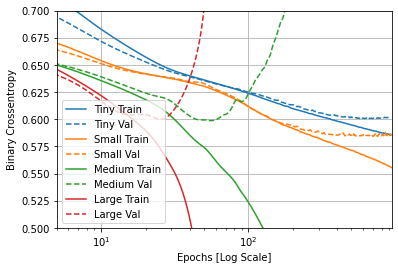

In [25]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

**The models all used `callbacks.EarlyStopping` to end the training when the model was clearly no longer making any progress**

something about tensorboard [https://www.tensorflow.org/tutorials/keras/overfit_and_underfit#view_in_tensorboard]

# Strategies to prevent overfitting
First we're just copying the training lofs of the `Tiny` model. We're going to use this model as a baseline of some comparisons.

In [26]:
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

PosixPath('/var/folders/43/vg26n99561513nys7wd_r9pc0000gn/T/tmp__rusxqs/tensorboard_logs/regularizers/Tiny')

In [27]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

Occam's Razor principle: given two explanations for something, the explanation most likely to be correct is the "simplest" one, the one that makes the least amount of assumptions. The same thing applies to neural network models, when there are multiple models that could explain the model the simpler ones are less likely to overfit than the more complex ones. 

A "simple model" (in this context) is a model where the distribution of parameter values has less entropy or a model with fewer parameters altogether.

A common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights only to take small values, which makes the distribution of weight values more "regular". This is called "weight regularization", and it is done by adding to the loss function of the network a cost associated with having large weights. This cost comes in two flavors:

- [L1 regularization](https://developers.google.com/machine-learning/glossary/#L1_regularization), where the cost added is proportional to the absolute value of the weights coefficients (i.e. to what is called the "L1 norm" of the weights).

- [L2 regularization](https://developers.google.com/machine-learning/glossary/#L2_regularization), where the cost added is proportional to the square of the value of the weights coefficients (i.e. to what is called the squared "L2 norm" of the weights). L2 regularization is also called weight decay in the context of neural networks. Don't let the different name confuse you: weight decay is mathematically the exact same as L2 regularization.

**L1 Regularization** pushes weights toward zero, which creates a sparse model. **L2 regularization** works on models without making them sparse (as the penalty for nodes with small weights goes to zero) -- this is why **L2 regularization** is more common.

In `tf.keras`, weight regularization is added by passing weight regularizer instances to layers as keyword arguments.

In [28]:
l2_model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(
            512,
            activation="elu",
            kernel_regularizer=tf.keras.regularizers.l2(0.001),
            input_shape=(FEATURES,),
        ),
        tf.keras.layers.Dense(
            512, activation="elu", kernel_regularizer=tf.keras.regularizers.l2(0.001)
        ),
        tf.keras.layers.Dense(
            512, activation="elu", kernel_regularizer=tf.keras.regularizers.l2(0.001)
        ),
        tf.keras.layers.Dense(
            512, activation="elu", kernel_regularizer=tf.keras.regularizers.l2(0.001)
        ),
        tf.keras.layers.Dense(1),
    ]
)

regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2")


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 512)               14848     
                                                                 
 dense_15 (Dense)            (None, 512)               262656    
                                                                 
 dense_16 (Dense)            (None, 512)               262656    
                                                                 
 dense_17 (Dense)            (None, 512)               262656    
                                                                 
 dense_18 (Dense)            (None, 1)                 513       
                                                                 
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5127,  binary_crossentropy

Each coefficient in the weight matrix of the layer will add 0.001 * weight_coefficient_value^2 to the **total loss** of the network. 

That is why we're monitoring the `binary_crossentropy` directly. Because it doesn't have this regularization component mixed in.

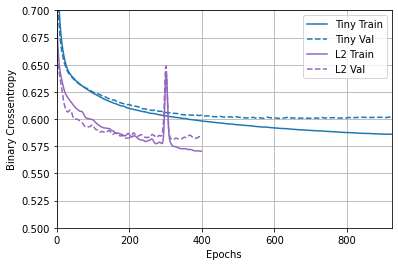

In [29]:
plotter.plot(regularizer_histories)
_ = plt.ylim((0.5, 0.7))

With the **L2 regularization** applied the larger model is much more competetive with the `Tiny` one. Despite having the same number of parameters as the `Large` model, with **L2 regularization** applied it's much less suceptible to overfitting (despite having the same number of parameters).

#### Other notes
1. when creating your own model you have to get its regularization losses

In [30]:
result = l2_model(features)
regularization_loss=tf.add_n(l2_model.losses)

1. this implementation adds the weight's penalties to the model's loss, and then applies a standard optimization (something like adam?)

2. another approach runs the optimizer on the "raw loss," and while applying the calculated step the optimizer also includes some weight decay. This "decoupled weight decay" is used in optimizers like `tf.keras.optimizers.Ftrl` and `tfa.optimizers.AdamW`.

## Adding dropout


Dropout is the most commonly used (and **most effective**) regularization techniques for neural networks. The intuitive explanation for dropout is that because individual nodes in the network cannot rely on the output of the others, each node must output features that are useful on their own.

Dropout onsists of randomly "dropping out" (setting the weight to zero) a number of output features during training. For example, a given layer would normally have returned a vector `[0.2, 0.5, 1.3, 0.8, 1.1]`; after applying dropout, this vector will have a few zero entries distributed at random: `[0, 0.5, 1.3, 0, 1.1]`.

The dropout *rate* is the fraction of features/weights that are being dropped (zeroed-out); it's typically between 0.2 and 0.5. At test time, no units are dropped out, and instead the layer's output values are scaled down by a factor equal to the dropout rate, so as to balance for the fact that more units are active than at training time.

In Keras, you can introduce dropout in a network via the `tf.keras.layers.Dropout` layer, which gets applied to the output of layer right before.

In [31]:
dropout_model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='elu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='elu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='elu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout")

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 512)               14848     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_20 (Dense)            (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_21 (Dense)            (None, 512)               262656    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_22 (Dense)            (None, 512)              

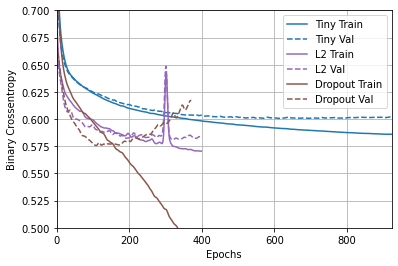

In [32]:
plotter.plot(regularizer_histories)
_ = plt.ylim([0.5, 0.7])

These models are both better than without, but they still don't bead the `Tiny` baseline.

In [33]:
combined_model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.0001),
                 activation='elu', input_shape=(FEATURES,)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.0001),
                 activation='elu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.0001),
                 activation='elu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.0001),
                 activation='elu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined")

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 512)               14848     
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_25 (Dense)            (None, 512)               262656    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_26 (Dense)            (None, 512)               262656    
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_27 (Dense)            (None, 512)              

# Notes
#### Most common ways to prevent overfitting
- get more training data
- reduce capacity/size of the network
- add weight regulizers
- add dropout
#### two other things to consider (that weren't part of the guide)
- data augmentation
- batch normalization

#### a combination is more effective!